In [47]:
import argparse
import torch
from tqdm import tqdm
import data_loader.data_loaders as module_data
import loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser

import torch.nn.functional as F
import sys
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

print(os.getcwd())

import data_loader.data_loaders as module_data
import model.model as module_arch

config_file = './hyperparams/multistep/config_cifar10_gce.json'
with open(config_file, 'r') as f:
    config = json.load(f)

resume_path = './saved/models/asym_40_gce.pth'
base_model = getattr(module_arch, config["arch"]['type'])()
checkpoint = torch.load(resume_path)
state_dict = checkpoint['state_dict']
base_model.load_state_dict(state_dict)


/home/jaychoi/ELR/ELR


<All keys matched successfully>

In [53]:
# set seed
random.seed(config['seed'])
torch.manual_seed(config['seed'])
torch.cuda.manual_seed_all(config['seed'])
torch.backends.cudnn.deterministic = True
np.random.seed(config['seed'])

data_loader = getattr(module_data, config['data_loader']['type'])(
    config['data_loader']['args']['data_dir'],
    batch_size= 100,
    shuffle=config['data_loader']['args']['shuffle'],
    validation_split=0.0,
    num_batches=config['data_loader']['args']['num_batches'],
    training=True,
    num_workers=config['data_loader']['args']['num_workers'],
    pin_memory=config['data_loader']['args']['pin_memory'],
    config=config
)
criterion = getattr(module_loss, 'GCELoss')(q=config['train_loss']['args']['q'],
                                                     k=config['train_loss']['args']['k'],
                                                     truncated=False)
device = torch.device('cuda:1')

Files already downloaded and verified
Train: 50000 Val: 0


In [110]:
isNoisy_list = np.empty((0,))
isFalse_list = np.empty((0,))
label_list = np.empty((0,))
loss_list = np.empty((0,))
base_model.eval()
base_model.to(device)
with tqdm(data_loader) as progress:
    for batch_idx, (data, label, index, label_gt) in enumerate(progress):
        data = data.to(device)
        label, label_gt = label.long().to(device), label_gt.long().to(device)
        output = base_model(data)
#         loss = criterion(output, label, None) # set index as None: not truncated
        loss, pred = torch.max(F.softmax(output, dim=1), dim=1)
        isNoisy = label != label_gt
        isFalse = pred != label_gt
        label_list = np.concatenate((label_list, label.cpu()))
        isNoisy_list = np.concatenate((isNoisy_list, isNoisy.cpu()))
        isFalse_list = np.concatenate((isFalse_list, isFalse.cpu()))
#         loss = np.expand_dims(loss.detach().cpu().numpy(), axis=0)
        loss = loss.detach().cpu().numpy()
        loss_list = np.concatenate((loss_list, loss), axis=0)

100%|██████████| 500/500 [00:12<00:00, 41.40it/s]


(0.8, 1.0)

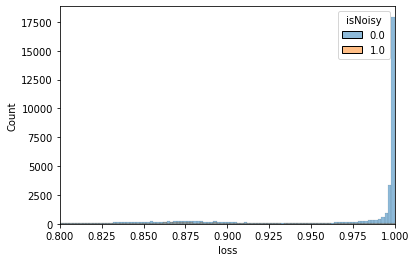

In [111]:
df = pd.DataFrame({"isNoisy": isNoisy_list, "loss" : loss_list, "isFalse": isFalse_list, "label": label_list})
max_loss_row = df['loss'].argmax()
max_loss = df.iloc[max_loss_row]['loss']
ax = sns.histplot(data=df, x="loss", bins=np.linspace(0,1.0,500), hue='isNoisy')
# ax.set_ylim([0, 1000])
ax.set_xlim([0.8, 1.0])

In [66]:
np.sum(df['isNoisy']),  np.sum(df['isNoisy']==0)

(9206.0, 40794)

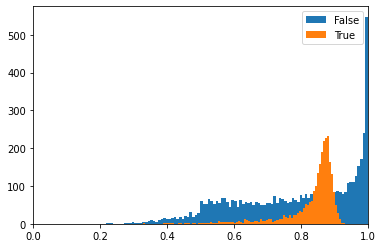

In [124]:
plt.hist(df['loss'][df['isFalse']==1], bins=100, label='False')
plt.hist(df['loss'][df['isFalse']==0][df['label']==4], bins=100, label='True')
plt.xlim(0,1.0)
plt.legend()

### Classify Data with confidence 0.999

### Clean or Nosiy

In [115]:
np.sum(df['loss'][df['isNoisy']==0]>0.999), np.sum(df['loss'][df['isNoisy']==1]>0.999) # noisy

(11265, 20)

### True or False

In [116]:
np.sum(df['loss'][df['isFalse']==0]>0.999), np.sum(df['loss'][df['isFalse']==1]>0.999) # noisy

(11227, 58)

### Label distribution

In [119]:
total_data = 0
for i in range(10):
    num_data = np.sum(df['loss'][df['label'] == i]>0.999)
    total_data += num_data
    print("label ", str(i), " : ", num_data)
print("total : ", total_data)

label  0  :  1568
label  1  :  1900
label  2  :  10
label  3  :  13
label  4  :  4
label  5  :  6
label  6  :  3183
label  7  :  2627
label  8  :  1971
label  9  :  3
total :  11285


------

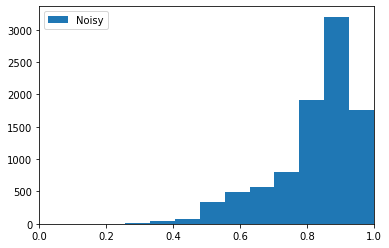

In [91]:
plt.hist(df['loss'][df['isNoisy']==1], bins=10, label='Noisy')
plt.xlim(0.0,1.0)
plt.legend()

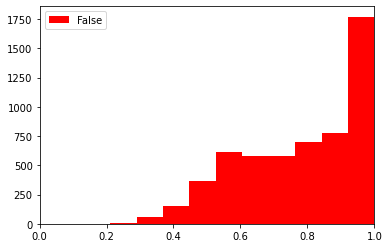

In [108]:
plt.hist(df['loss'][df['isFalse']==1], bins=10, label='False', color = 'red')
plt.xlim(0.0,1.0)
plt.legend()